In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import catboost as cb
from tqdm.notebook import tqdm

# from xgboost import plot_importance, plot_tree

# from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import random

plt.style.use('default')

In [3]:
!nvidia-smi

Sun Apr 28 22:14:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti      On | 00000000:65:00.0 Off |                  N/A |
|  0%   46C    P2               36W / 285W|    420MiB / 12282MiB |      8%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Functions

In [4]:
def ts_array_create(dirname, dir_list, time_seq):
    
    columns = ['RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2',
               'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2']
    
    def reamin_HO_time(y_train):
        def f(L):    
            for i, e in enumerate(L):
                if e: return i+1
            return 0

        out = []
        for a2 in y_train:
            a1_out = []
            for a1 in a2:
                a1_out.append(a1.any())
      
            out.append(f(a1_out))
        return out
    
    def HO(y_train):
        out = []
        for a2 in y_train:
            if sum(a2.reshape(-1)) == 0: ho = 0
            elif sum(a2.reshape(-1)) > 0: ho = 1
            out.append(ho)
        return out

    split_time = []
    for i, f in enumerate(tqdm(dir_list)):
    
        f = os.path.join(dirname, f)
        df = pd.read_csv(f)

        
        # preprocess data with ffill method
        del df['Timestamp'], df['lat'], df['long'], df['gpsspeed']
        # df[columns] = df[columns].replace(0, np.nan)
        # df[columns] = df[columns].fillna(method='ffill')
        # df.dropna(inplace=True)
        
        df.replace(np.nan,0,inplace=True); df.replace('-',0,inplace=True)
        
        X = df[features]
        Y = df[target]

        Xt_list = []
        Yt_list = []

        for j in range(time_seq):
            X_t = X.shift(periods=-j)
            Xt_list.append(X_t)
    
        for j in range(time_seq,time_seq+predict_t):
            Y_t = Y.shift(periods=-(j))
            Yt_list.append(Y_t)

        # YY = Y.shift(periods=-(0))

        X_ts = np.array(Xt_list); X_ts = np.transpose(X_ts, (1,0,2)); X_ts = X_ts[:-(time_seq+predict_t-1),:,:]
        Y_ts = np.array(Yt_list); Y_ts = np.transpose(Y_ts, (1,0,2)); Y_ts = Y_ts[:-(time_seq+predict_t-1),:,:]
        split_time.append(len(X_ts))

        if i == 0:
            X_final = X_ts
            Y_final = Y_ts
        else:
            X_final = np.concatenate((X_final,X_ts), axis=0)
            Y_final = np.concatenate((Y_final,Y_ts), axis=0)

    split_time = [(sum(split_time[:i]), sum(split_time[:i])+x) for i, x in enumerate(split_time)]
    
    return X_final, np.array(HO(Y_final)), np.array(reamin_HO_time(Y_final)), split_time # forecast HO


In [5]:
def days_in_file(file, dates):
    
    for date in dates:
        if date in file: return True 
    return False

def train_valid_split(L, valid_size=0.2):
    
    length = len(L)
    v_num = int(length*valid_size)
    v_files = random.sample(L, v_num)
    t_files = list(set(L) - set(v_files))
    
    return t_files, v_files

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    print(f"Random seed set as {seed}")

# Load Data

In [6]:
# Time sequence length and prediction time length
seed = 55688
time_seq = 20
predict_t = 2
valid_ratio = 0.2
task = 'classification'

In [7]:
# Setup seed
set_seed(seed)

# Get GPU
device_count = torch.cuda.device_count()
num_of_gpus = device_count

for i in range(device_count):
    print("GPU {}: {}".format(i, torch.cuda.get_device_name(i)))
    gpu_id = i

# Save best model to 
save_path = "../model"

# Define DataSet
dirname = "../data/single"
# dirname = "/home/wmnlab/Documents/sheng-ru/data/single0.5"
dir_list = os.listdir(dirname)
dir_list = [f for f in dir_list if ( f.endswith('.csv') and (not 'sm' in f) ) ] # Take out cell phone data

# train_dates = ['03-26', '04-01']
# test_dates = ['04-10']
    
# train_dir_list = [f for f in dir_list if ( f.endswith('.csv') and ('All' in f) and days_in_file(f, train_dates) )]
# test_dir_list = [f for f in dir_list if ( f.endswith('.csv') and ('All' in f) and days_in_file(f, test_dates) )]

train_dir_list, test_dir_list = train_valid_split(dir_list, valid_ratio)
# train_dir_list += [f for f in os.listdir(dirname) if 'sm' in f] # Add cell phone data.

# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2',
#         'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2' ]
features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
        'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']
# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2']

num_of_features = len(features)

# target = ['LTE_HO', 'MN_HO'] # For eNB HO.
# target = ['eNB_to_ENDC'] # Setup gNB
# target = ['gNB_Rel', 'gNB_HO'] # For gNB HO.
target = ['RLF'] # For RLF
# target = ['SCG_RLF'] # For scg failure
# target = ['dl-loss'] # For DL loss
# target = ['ul-loss'] # For UL loss

# Data
print('Loading training data...')
X_train, y_train1, y_train2, split_time_train = ts_array_create(dirname, train_dir_list, time_seq)
X_train_2d = X_train.reshape(-1, time_seq*num_of_features)
cond = y_train2 > 0
X_train_fore = X_train_2d[cond]
y_train2_fore = y_train2[cond]


print('Loading testing data...')
X_test, y_test1, y_test2, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
X_test_2d = X_test.reshape(-1, time_seq*num_of_features)
cond = y_test2 > 0
X_test_fore = X_test_2d[cond]
y_test2_fore = y_test2[cond]


Random seed set as 55688
GPU 0: NVIDIA GeForce RTX 4070 Ti
GPU 1: NVIDIA GeForce RTX 4070 Ti
Loading training data...


  0%|          | 0/136 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/33 [00:00<?, ?it/s]

# 特別任務處理

In [8]:
# Time sequence length and prediction time length
time_seq = 20
predict_t = 10
valid_ratio = 0.2

# Define DataSet
dirname = "../data/single"
# dirname = "/home/wmnlab/Documents/sheng-ru/data/single0.5"
dir_list = os.listdir(dirname)
dir_list = [f for f in dir_list if ( f.endswith('.csv') and (not '08-21' in f) ) ] # Take out cell phone data

train_dir_list, test_dir_list = train_valid_split(dir_list, valid_ratio)
# train_dir_list += [f for f in os.listdir(dirname) if 'sm' in f] # Add cell phone data.

# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2',
#         'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2' ]
features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
        'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']
# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2']

num_of_features = len(features)

target = ['LTE_HO', 'MN_HO'] # For eNB HO.
# target = ['eNB_to_ENDC'] # Setup gNB
# target = ['gNB_Rel', 'gNB_HO'] # For gNB HO.
# target = ['RLF'] # For RLF
# target = ['SCG_RLF'] # For scg failure
# target = ['dl-loss'] # For DL loss
# target = ['ul-loss'] # For UL loss

# Data
print('Loading training data...')
X_train, y_train1, y_train2, split_time_train = ts_array_create(dirname, train_dir_list, time_seq)
X_train_2d = X_train.reshape(-1, time_seq*num_of_features)
cond = y_train2 > 0
X_train_fore = X_train_2d[cond]
y_train2_fore = y_train2[cond]


print('Loading testing data...')
X_test, y_test1, y_test2, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
X_test_2d = X_test.reshape(-1, time_seq*num_of_features)
cond = y_test2 > 0
X_test_fore = X_test_2d[cond]
y_test2_fore = y_test2[cond]


Loading training data...


  0%|          | 0/296 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

In [9]:
L = []
record_file = '../info/2023-09-09-record.csv'

f = open(record_file, 'w')
f.write(','.join([ 'num','roc_auc', 'aucpr', 'p', 'r', 'f1']) + '\n')

for i, l in enumerate(train_dir_list):
    
    L.append(l)
    
    features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
        'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']
    
    num_of_features = len(features)
    
    target = ['LTE_HO', 'MN_HO'] # For eNB HO.
    # target = ['eNB_to_ENDC'] # Setup gNB
    # target = ['gNB_Rel', 'gNB_HO'] # For gNB HO.
    # target = ['RLF'] # For RLF
    # target = ['SCG_RLF'] # For scg failure
    # target = ['dl-loss'] # For DL loss
    # target = ['ul-loss'] # For UL loss
    
    
    # Data
    print('Loading training data...')
    X_train, y_train1, y_train2, split_time_train = ts_array_create(dirname, L, time_seq)
    X_train_2d = X_train.reshape(-1, time_seq*num_of_features)
    cond = y_train2 > 0
    X_train_fore = X_train_2d[cond]
    y_train2_fore = y_train2[cond]


    print('Loading testing data...')
    X_test, y_test1, y_test2, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
    X_test_2d = X_test.reshape(-1, time_seq*num_of_features)
    cond = y_test2 > 0
    X_test_fore = X_test_2d[cond]
    y_test2_fore = y_test2[cond]
    
    model = cb.CatBoostClassifier(iterations=200,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,
                              colsample_bylevel=0.8, scale_pos_weight=1,
                              loss_function='Logloss', eval_metric = 'F1', early_stopping_rounds=10, random_seed=seed) 
    
    model.fit(X_train_2d, y_train1, eval_set=(X_test_2d, y_test1), verbose=False)
    # 選擇最佳迭代次數
    best_iteration = model.best_iteration_

    # 使用最佳迭代次數重新訓練模型
    model = cb.CatBoostClassifier(iterations=200,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,
                                colsample_bylevel=0.8, scale_pos_weight=1,
                                loss_function='Logloss', eval_metric = 'F1', early_stopping_rounds=10, random_seed=seed)
    model.fit(X_train_2d, y_train1, eval_set=(X_test_2d, y_test1), verbose=False)
    
    preds = model.predict_proba(X_test_2d)[:, 1]
    
    # PR and AUCPR
    precision, recall, thresholds = precision_recall_curve(y_test1, preds)
    
    p = precision_score(y_test1, [1 if (p >= 0.5) else 0 for p in preds]) 
    r = recall_score(y_test1, [1 if (p >= 0.5) else 0 for p in preds])
    f1 = f1_score(y_test1, [1 if (p >= 0.5) else 0 for p in preds])
    
    aucpr = auc(recall, precision)
    
    # ROC & AUC
    fpr, tpr, thresholds = roc_curve(y_test1, preds)
    roc_auc = auc(fpr, tpr)
    
    print(i, roc_auc, aucpr, p, r, f1)
    write_list = [ i+1, roc_auc, aucpr, p, r, f1]
    write_list = [str(s) for s in write_list]
    f.write(','.join(write_list) + '\n')
    

f.close()


Loading training data...


  0%|          | 0/1 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

0 0.5341230426185406 0.4791619366564873 0.4779610194902549 0.4232607541157727 0.4489508519926771
Loading training data...


  0%|          | 0/2 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

1 0.5531505386536979 0.477325232529261 0.4725609756097561 0.38413878562577447 0.42378673957621327
Loading training data...


  0%|          | 0/3 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

2 0.5343891539898715 0.45190112462420096 0.4532755724515958 0.45379713223579393 0.45353620239727543
Loading training data...


  0%|          | 0/4 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

3 0.5860425020462158 0.5037382353791071 0.5071652485445589 0.4009559214020181 0.4478497281265447
Loading training data...


  0%|          | 0/5 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

4 0.5788091005777474 0.4895629771521111 0.4931553343138364 0.38582049920339884 0.4329343993643542
Loading training data...


  0%|          | 0/6 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

5 0.6163545053912892 0.5408637927783552 0.5501422035365401 0.39378651088688266 0.4590147020892443
Loading training data...


  0%|          | 0/7 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

6 0.5808598869140414 0.4974959356264814 0.5126868742285009 0.3308550185873606 0.40217332831244285
Loading training data...


  0%|          | 0/8 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

7 0.5982593906865451 0.518230448615969 0.545326278659612 0.2736767569481324 0.36445073078736445
Loading training data...


  0%|          | 0/9 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

8 0.6543109190570626 0.5677011912429711 0.5839317773788151 0.3454593733404142 0.43410076743410075
Loading training data...


  0%|          | 0/10 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

9 0.6150220875534878 0.5235149603080964 0.5360271572492334 0.43326252434059126 0.47919725893294174
Loading training data...


  0%|          | 0/11 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

10 0.5831565728776237 0.5027358460434858 0.4807845005558202 0.5359355638166047 0.5068642223338355
Loading training data...


  0%|          | 0/12 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

11 0.6495287751574726 0.5697013143410701 0.5787030897758918 0.38626305540803685 0.4632942300546738
Loading training data...


  0%|          | 0/13 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

12 0.6925249818406948 0.6047149521663445 0.6164748637189582 0.45043370508054525 0.5205339334117527
Loading training data...


  0%|          | 0/14 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

13 0.6276489637395952 0.5385787187559783 0.5467980295566502 0.44211364843335105 0.4889149904566143
Loading training data...


  0%|          | 0/15 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

14 0.6847176686742991 0.6081269488911257 0.6116037496833038 0.4273322711984422 0.5031263026260943
Loading training data...


  0%|          | 0/16 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

15 0.7440446667871272 0.6650667164921262 0.6533665835411472 0.5797486280757657 0.6143600806640717
Loading training data...


  0%|          | 0/17 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

16 0.7430875507840913 0.6675699651972796 0.6444444444444445 0.572402195078775 0.6062907232925514
Loading training data...


  0%|          | 0/18 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

17 0.7415320563917901 0.6598263896470371 0.6492199295420231 0.5708975039830059 0.6075448594169454
Loading training data...


  0%|          | 0/19 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

18 0.7372752957569499 0.6638500898882346 0.6490453592318729 0.5205346078952027 0.5777297509700869
Loading training data...


  0%|          | 0/20 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

19 0.6481638541673479 0.565696390082487 0.5775102395432543 0.41184280403611256 0.4808059932833893
Loading training data...


  0%|          | 0/21 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

20 0.7340626080746191 0.6677115668971163 0.6355197388554524 0.5514250309789344 0.590493341547794
Loading training data...


  0%|          | 0/22 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

21 0.7358755371997505 0.6589618576589498 0.633997239203313 0.5691272791644539 0.5998134328358209
Loading training data...


  0%|          | 0/23 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

22 0.6771274292816147 0.5923795444372661 0.5840377648479526 0.4708798017348203 0.5213897192139952
Loading training data...


  0%|          | 0/24 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

23 0.7374618196641498 0.6600040258596893 0.6422951851463338 0.5419543281996814 0.5878738418702895
Loading training data...


  0%|          | 0/25 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

24 0.743183112910389 0.6750350638155782 0.6455605564648118 0.5585944414940698 0.5989370788649521
Loading training data...


  0%|          | 0/26 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

25 0.6476992609683578 0.5718098203036569 0.5668272662384012 0.5623119136130289 0.5645605616280103
Loading training data...


  0%|          | 0/27 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

26 0.7363368520943516 0.6577596278588752 0.6454965357967667 0.5442556204637989 0.5905685747214752
Loading training data...


  0%|          | 0/28 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

27 0.7368175271480228 0.6625707767505079 0.638966330688398 0.5274384846875553 0.5778704422032583
Loading training data...


  0%|          | 0/29 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

28 0.7552869819324755 0.6845234606365056 0.6563433578968333 0.5833775889537971 0.6177132146204312
Loading training data...


  0%|          | 0/30 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

29 0.6368085223813265 0.553293894190569 0.5369702434625789 0.5270844397238449 0.5319814186171163
Loading training data...


  0%|          | 0/31 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

30 0.756938443400572 0.6895201990357617 0.6608928755541809 0.5673570543459019 0.6105634138210221
Loading training data...


  0%|          | 0/32 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

31 0.7508277525039665 0.6786084215760615 0.6569327731092437 0.5535493007611967 0.6008262080891537
Loading training data...


  0%|          | 0/33 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

32 0.7641551377246938 0.7046210172181017 0.6651667807884183 0.601876438307665 0.6319408949398262
Loading training data...


  0%|          | 0/34 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

33 0.7644665200678024 0.7016702865295273 0.6738336290575097 0.5714285714285714 0.6184204224340246
Loading training data...


  0%|          | 0/35 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

34 0.7663762083023056 0.7024542288147805 0.6715615305067218 0.5747919985838201 0.6194200686760778
Loading training data...


  0%|          | 0/36 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

35 0.7528718690838293 0.689187956722108 0.6607422895974908 0.5593910426624181 0.6058572592628098
Loading training data...


  0%|          | 0/37 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

36 0.7740045040150564 0.7120693695721358 0.6780299175740307 0.5897503983005842 0.6308165680473373
Loading training data...


  0%|          | 0/38 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

37 0.7583284801922586 0.6973540962960162 0.6728745791245792 0.5660293857319879 0.6148447264686088
Loading training data...


  0%|          | 0/39 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

38 0.7715471394504456 0.7094712014027678 0.6793410692084542 0.5803682067622588 0.6259665871121718
Loading training data...


  0%|          | 0/40 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

39 0.7778074621639903 0.7168393321723013 0.6876525630593979 0.5984244999114887 0.6399432087079981
Loading training data...


  0%|          | 0/41 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

40 0.7808853939682796 0.7249054994942089 0.6876898157521766 0.6012568596211719 0.6415753683415187
Loading training data...


  0%|          | 0/42 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

41 0.76218304260401 0.6917242000738966 0.668870751110652 0.5730217737652682 0.6172474615054584
Loading training data...


  0%|          | 0/43 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

42 0.7751823651354108 0.7180536063352462 0.6815955927361763 0.591343600637281 0.6332701421800948
Loading training data...


  0%|          | 0/44 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

43 0.772492273712464 0.7107614916948501 0.681635181170641 0.5844397238449283 0.6293066476054324
Loading training data...


  0%|          | 0/45 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

44 0.7752047505054336 0.7138174399840509 0.6788187372708757 0.590015932023367 0.6313097831234018
Loading training data...


  0%|          | 0/46 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

45 0.788750263559594 0.7294446760901632 0.6990831358813228 0.6006372809346787 0.6461318733634849
Loading training data...


  0%|          | 0/47 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

46 0.776681232104582 0.722249842419864 0.6887727902761488 0.5717826163922818 0.6248488658896358
Loading training data...


  0%|          | 0/48 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

47 0.7835201204577069 0.7290989965590607 0.6992845117845118 0.5882457072048151 0.6389770214402462
Loading training data...


  0%|          | 0/49 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

48 0.7877974293019814 0.7358526315264956 0.702604611443211 0.5825809877854488 0.6369882899448369
Loading training data...


  0%|          | 0/50 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

49 0.7893369996508026 0.7361813330744923 0.7007667261842243 0.5905469994689325 0.6409529756472453
Loading training data...


  0%|          | 0/51 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

50 0.7894935543176091 0.7375398563607166 0.70479349454312 0.5830235439900867 0.6381515210230575
Loading training data...


  0%|          | 0/52 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

51 0.7773683301646631 0.7247233497553729 0.6902570612503967 0.5775358470525757 0.6288853549226543
Loading training data...


  0%|          | 0/53 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

52 0.7808405696319773 0.7259726373529088 0.6942400672692873 0.5846167463267835 0.6347299634826062
Loading training data...


  0%|          | 0/54 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

53 0.7828359285057851 0.7311294790560346 0.6924931851541204 0.5846167463267835 0.6339988481474371
Loading training data...


  0%|          | 0/55 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

54 0.7947860298664309 0.745524114298486 0.7144084174361177 0.5889537971322358 0.6456433145740346
Loading training data...


  0%|          | 0/56 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

55 0.7798337818089468 0.7276372337582221 0.695754464763127 0.5758541334749513 0.6301515811903724
Loading training data...


  0%|          | 0/57 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

56 0.7851319326058749 0.734656873722521 0.7044972422571065 0.5878916622411047 0.6409340924442729
Loading training data...


  0%|          | 0/58 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

57 0.7954202165105366 0.7457497328810183 0.7191646726125734 0.5852363250132767 0.6453250048799531
Loading training data...


  0%|          | 0/59 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

58 0.787487976424126 0.7376757315363838 0.7049336870026525 0.5880686847229598 0.6412199005935434
Loading training data...


  0%|          | 0/60 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

59 0.794183846142916 0.74748636134029 0.7091567511639938 0.6066560453177554 0.6539140390211324
Loading training data...


  0%|          | 0/61 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

60 0.786479009019976 0.7344320823271294 0.6997424008243174 0.6010798371393167 0.6466695234014188
Loading training data...


  0%|          | 0/62 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

61 0.7964864544929009 0.7481003607756038 0.7067676977371808 0.6026730394760135 0.6505828396713167
Loading training data...


  0%|          | 0/63 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

62 0.7951956303281305 0.7470575785505873 0.7088555578385042 0.6107275624004248 0.6561430201597566
Loading training data...


  0%|          | 0/64 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

63 0.7940256478575605 0.7434602753447872 0.7142392012155415 0.5824924765445212 0.6416731669266771
Loading training data...


  0%|          | 0/65 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

64 0.7957722129062003 0.748880619976269 0.7140895648500212 0.5984244999114887 0.6511605509005105
Loading training data...


  0%|          | 0/66 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

65 0.7987303511208711 0.7513326625069379 0.7166454891994918 0.5990440785979819 0.6525889499566098
Loading training data...


  0%|          | 0/67 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

66 0.7962889403754384 0.7497959934799583 0.7123977344241661 0.6011683483802442 0.652073732718894
Loading training data...


  0%|          | 0/68 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

67 0.7965301473526658 0.7483645814208995 0.7126351494594022 0.5950610727562401 0.6485626085278796
Loading training data...


  0%|          | 0/69 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

68 0.797700308477426 0.7486946859830378 0.7157147466924815 0.5889537971322358 0.6461762563729061
Loading training data...


  0%|          | 0/70 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

69 0.7855969932833289 0.7318964008641802 0.706345780271962 0.5793060718711276 0.6365493094728653
Loading training data...


  0%|          | 0/71 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

70 0.7960667779348782 0.750869981638529 0.7080802882141018 0.6088688263409453 0.6547375434254985
Loading training data...


  0%|          | 0/72 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

71 0.7813497549168223 0.728650421510289 0.7001603420630679 0.5797486280757657 0.6342904178569699
Loading training data...


  0%|          | 0/73 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

72 0.8012696226765144 0.7545793916059904 0.7255788906838988 0.5963002301292264 0.6546178885488024
Loading training data...


  0%|          | 0/74 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

73 0.7983490256623287 0.7512464270743722 0.7143301534632932 0.6097539387502213 0.6579123292904212
Loading training data...


  0%|          | 0/75 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

74 0.7861347007096275 0.7341783073895032 0.6970258310178038 0.5994866348026199 0.6445871996193195
Loading training data...


  0%|          | 0/76 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

75 0.7931460558627594 0.747159913355872 0.7013171225937184 0.612674809700832 0.6540060468631897
Loading training data...


  0%|          | 0/77 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

76 0.7760617367900442 0.7262639612362642 0.6952340695339744 0.5823154540626659 0.6337844997832475
Loading training data...


  0%|          | 0/78 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

77 0.790013831050091 0.741170098009587 0.7019648397104447 0.6008143034165339 0.6474628004578405
Loading training data...


  0%|          | 0/79 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

78 0.7944304425215457 0.7487894039703447 0.7036354326676907 0.6081607364135245 0.6524236813369415
Loading training data...


  0%|          | 0/80 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

79 0.793444753758369 0.7492592229414343 0.7079388201019665 0.6022304832713755 0.6508202209574824
Loading training data...


  0%|          | 0/81 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

80 0.8085178494651932 0.7633303662548044 0.7304058406699592 0.6021419720304478 0.6601009120900446
Loading training data...


  0%|          | 0/82 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

81 0.7976121366794595 0.7494043177942492 0.7122641509433962 0.6014338821030271 0.6521739130434783
Loading training data...


  0%|          | 0/83 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

82 0.8103266993196503 0.7655677811730084 0.7329737732656514 0.6134714108691803 0.667919437216922
Loading training data...


  0%|          | 0/84 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

83 0.8062767696182875 0.7620558769556448 0.7230095873280533 0.6140909895556735 0.6641140997415526
Loading training data...


  0%|          | 0/85 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

84 0.805291855023268 0.7596755804137095 0.7204356846473029 0.6147105682421667 0.6633871429936001
Loading training data...


  0%|          | 0/86 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

85 0.8041537563704958 0.7590162244325179 0.7232651339379877 0.6070100902814658 0.6600577478344563
Loading training data...


  0%|          | 0/87 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

86 0.8114656019162783 0.7691825014357674 0.7294290512174643 0.6151531244468047 0.6674349370978584
Loading training data...


  0%|          | 0/88 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

87 0.8152153747128119 0.772979185233338 0.7424258530881258 0.618162506638343 0.67461965708766
Loading training data...


  0%|          | 0/89 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

88 0.8006688741416603 0.7530002692631209 0.7251694824061121 0.5964772526110816 0.6545578165217814
Loading training data...


  0%|          | 0/90 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

89 0.815297454402895 0.7741745057260243 0.7334927732141 0.6243582935032749 0.6745398039684437
Loading training data...


  0%|          | 0/91 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

90 0.7980570630296866 0.7516667093745526 0.7143006700167505 0.6039121968489998 0.654484412470024
Loading training data...


  0%|          | 0/92 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

91 0.813326178113916 0.7696433255250013 0.7320418848167539 0.6187820853248363 0.670663852647736
Loading training data...


  0%|          | 0/93 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

92 0.8105100402046963 0.7682388774646844 0.730130548302872 0.6187820853248363 0.6698605854453121
Loading training data...


  0%|          | 0/94 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

93 0.8051825782103084 0.7593185007224811 0.7232850650036994 0.6056824216675518 0.6592803121537646
Loading training data...


  0%|          | 0/95 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

94 0.8171700540275283 0.7766439915664147 0.7374578414839797 0.6193131527704019 0.6732416049263927
Loading training data...


  0%|          | 0/96 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

95 0.8171251403641309 0.7734145245454259 0.7359154929577465 0.62896087803151 0.6782475899589577
Loading training data...


  0%|          | 0/97 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

96 0.8166744494387024 0.7738271764731807 0.7323096078024487 0.6247123384669853 0.6742453190676347
Loading training data...


  0%|          | 0/98 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

97 0.8145122037307593 0.7715862843723436 0.7436583538478005 0.6149761019649496 0.6732231965505547
Loading training data...


  0%|          | 0/99 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

98 0.8171631282000911 0.7716888528768281 0.7416800428036383 0.6134714108691803 0.6715109237998353
Loading training data...


  0%|          | 0/100 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

99 0.8216635582624127 0.7797497651957016 0.749057619816909 0.6155956806514428 0.6758004178205315
Loading training data...


  0%|          | 0/101 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

100 0.8227073394130784 0.7808604701724686 0.7454679595278246 0.6260400070808992 0.6805542191859906
Loading training data...


  0%|          | 0/102 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

101 0.822338531658124 0.7795745945709837 0.747481243301179 0.6172773942290671 0.6761683149117704
Loading training data...


  0%|          | 0/103 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

102 0.8226717753189641 0.7800698979036316 0.7451494493969586 0.6288723667905824 0.6820909134546153
Loading training data...


  0%|          | 0/104 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

103 0.8201518222364128 0.7784550129064743 0.7445859872611464 0.620817843866171 0.6770923834346945
Loading training data...


  0%|          | 0/105 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

104 0.8255494060004249 0.7826773978249706 0.7471385067730757 0.6297574791998584 0.683444599202728
Loading training data...


  0%|          | 0/106 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

105 0.8132300442942098 0.7691332064107864 0.7400212314225053 0.6170118605062843 0.6729414036103871
Loading training data...


  0%|          | 0/107 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

106 0.8203095560208744 0.776608790413356 0.7464429815247399 0.6222340237210126 0.6787024522108516
Loading training data...


  0%|          | 0/108 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

107 0.798963244723118 0.7476492846525162 0.7222761073391529 0.5932023366967605 0.6514069106283715
Loading training data...


  0%|          | 0/109 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

108 0.8253874738424956 0.7836442736065907 0.7505544408068434 0.6290493892724376 0.6844512929166466
Loading training data...


  0%|          | 0/110 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

109 0.8247493270305088 0.7846729280244937 0.7512728044123886 0.6269251194901753 0.6834893370645566
Loading training data...


  0%|          | 0/111 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

110 0.82670192800148 0.7840699822232444 0.7456508069587089 0.6297574791998584 0.6828214971209213
Loading training data...


  0%|          | 0/112 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

111 0.8294446985899552 0.7867116103703257 0.7510272890106416 0.6309081253319172 0.6857472701909664
Loading training data...


  0%|          | 0/113 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

112 0.8210776439804788 0.7769865144810255 0.7438648677361096 0.6197557089750398 0.6761624257640867
Loading training data...


  0%|          | 0/114 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

113 0.8195479115223937 0.7777052204844819 0.7449470644850819 0.6165693043016464 0.6747057968908906
Loading training data...


  0%|          | 0/115 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

114 0.822144138033849 0.78294950502155 0.7469650585875647 0.6263055408036821 0.6813345529825237
Loading training data...


  0%|          | 0/116 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

115 0.8242181166615911 0.7824892385467972 0.7487331081081081 0.6277217206585236 0.6829080404429465
Loading training data...


  0%|          | 0/117 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

116 0.8221248314710362 0.78305415663606 0.7452731092436975 0.6279872543813064 0.6816216735517341
Loading training data...


  0%|          | 0/118 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

117 0.8203627354181349 0.7761322187293538 0.7456047447574666 0.6231191361302886 0.6788813886210222
Loading training data...


  0%|          | 0/119 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

118 0.8141019482036957 0.7717882324206274 0.7402486980550537 0.6164807930607187 0.6727193702612643
Loading training data...


  0%|          | 0/120 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

119 0.8289492845655988 0.7877920060528543 0.7511574074074074 0.6318817489821207 0.6863763099701952
Loading training data...


  0%|          | 0/121 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

120 0.8226164282508633 0.7799554490135361 0.7453080267203902 0.622145512480085 0.6781803270780067
Loading training data...


  0%|          | 0/122 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

121 0.8277295171273806 0.7861230399722334 0.7500523560209424 0.6340060187643831 0.6871642363775902
Loading training data...


  0%|          | 0/123 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

122 0.8222710599256535 0.7801136261909658 0.744499792444998 0.6349796424145866 0.6853921849622624
Loading training data...


  0%|          | 0/124 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

123 0.8173634233677799 0.7730831977330506 0.7375820056232427 0.6269251194901753 0.6777666140376059
Loading training data...


  0%|          | 0/125 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

124 0.827212980222612 0.787837721378563 0.749819084048382 0.6419720304478669 0.6917171331839207
Loading training data...


  0%|          | 0/126 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

125 0.8126702492548721 0.7679790361360885 0.7331294812315479 0.6154186581695875 0.6691367529592916
Loading training data...


  0%|          | 0/127 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

126 0.8287820523333624 0.7873884809252664 0.7496121625814458 0.6415294742432289 0.6913721562455287
Loading training data...


  0%|          | 0/128 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

127 0.8209624239381274 0.7777866010399477 0.7472166260205705 0.6237387148167818 0.6799170244584881
Loading training data...


  0%|          | 0/129 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

128 0.8152291846817086 0.7699443713947615 0.7361924018303714 0.6123207647371216 0.6685672867842474
Loading training data...


  0%|          | 0/130 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

129 0.8279967361546903 0.7863903808123152 0.7483756025990358 0.6320587714639759 0.68531669865643
Loading training data...


  0%|          | 0/131 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

130 0.8294261304644615 0.789601920219901 0.7540776596864148 0.6342715524871658 0.6890053362819095
Loading training data...


  0%|          | 0/132 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

131 0.8313986513776317 0.7910508374641134 0.7526735164604739 0.6354221986192247 0.6890957957381455
Loading training data...


  0%|          | 0/133 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

132 0.82438186513712 0.7831788300016111 0.7508474576271187 0.6273676756948132 0.6835760439772398
Loading training data...


  0%|          | 0/134 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

133 0.8255657707242403 0.7844790986328459 0.7432488146773861 0.6382545583289078 0.6867619047619048
Loading training data...


  0%|          | 0/135 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

134 0.8331485810801853 0.7899119742955287 0.7483824586628325 0.6449814126394052 0.6928452579034942
Loading training data...


  0%|          | 0/136 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

135 0.8326985869060985 0.7902994428100554 0.7512015543511606 0.6502035758541335 0.6970631494045643
Loading training data...


  0%|          | 0/137 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

136 0.8263920225330098 0.7830017575539747 0.7390811701689328 0.6350681536555143 0.683138151004475
Loading training data...


  0%|          | 0/138 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

137 0.8287457021608116 0.7852867173060367 0.7404307441053384 0.6420605416887945 0.6877459113534012
Loading training data...


  0%|          | 0/139 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

138 0.8348713434355608 0.7922291064214221 0.7499231950844855 0.6481678173127987 0.6953425437971799
Loading training data...


  0%|          | 0/140 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

139 0.8375147286980693 0.7947381800354236 0.75544695581348 0.6567534076827757 0.7026515151515151
Loading training data...


  0%|          | 0/141 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

140 0.829814745013961 0.7867888119593823 0.7476087627275533 0.6433882103027084 0.6915941201655488
Loading training data...


  0%|          | 0/142 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

141 0.835278002058263 0.790155770168194 0.7468648867313916 0.6536555142503098 0.6971585008968186
Loading training data...


  0%|          | 0/143 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

142 0.8365754304729285 0.7951877841250385 0.7484352917423783 0.6562223402372102 0.699302018487078
Loading training data...


  0%|          | 0/144 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

143 0.8360160582485074 0.7936890509973892 0.7458513527104496 0.6563993627190653 0.6982722094063368
Loading training data...


  0%|          | 0/145 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

144 0.8314515270627689 0.7871194438136693 0.740261054335728 0.6475482386263055 0.6908077994428969
Loading training data...


  0%|          | 0/146 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

145 0.8332246103483629 0.7893732412128022 0.7459074733096085 0.6493184634448576 0.6942696257038754
Loading training data...


  0%|          | 0/147 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

146 0.8315188558718873 0.7899316797353819 0.7416992677299629 0.6544521154186582 0.6953496026708045
Loading training data...


  0%|          | 0/148 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

147 0.8296143486088978 0.7849962306057496 0.7405253659514738 0.6537440254912373 0.6944339977435126
Loading training data...


  0%|          | 0/149 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

148 0.8116393103629066 0.7625651225157191 0.7241025641025641 0.6248893609488405 0.6708475864690232
Loading training data...


  0%|          | 0/150 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

149 0.8345286370577837 0.7919260125723506 0.74604943273906 0.6518852894317578 0.6957959376476146
Loading training data...


  0%|          | 0/151 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

150 0.8310814210873664 0.7885638839034295 0.7422244589833921 0.6526818906001062 0.6945791927659775
Loading training data...


  0%|          | 0/152 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

151 0.8359006357314073 0.792389200136056 0.7428571428571429 0.6604708798017348 0.6992456543128894
Loading training data...


  0%|          | 0/153 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

152 0.8309857458134147 0.7879186646698575 0.744982170147733 0.6471941936625951 0.6926538151849572
Loading training data...


  0%|          | 0/154 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

153 0.8489174872164291 0.8095658088502207 0.7587723682895131 0.6718003186404673 0.7126425989390169
Loading training data...


  0%|          | 0/155 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

154 0.8439485663162032 0.8022075703493047 0.7568364338721155 0.6589661887059657 0.704518571090608
Loading training data...


  0%|          | 0/156 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

155 0.8470060243503041 0.8065393440569814 0.7637684083114787 0.6702071163037706 0.713935508202904
Loading training data...


  0%|          | 0/157 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

156 0.8465228600482507 0.8062472282078279 0.7643350955673038 0.6654275092936803 0.7114602063026403
Loading training data...


  0%|          | 0/158 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

157 0.8354710915069501 0.791882238842733 0.7451593384429205 0.6540095592140202 0.696615442632224
Loading training data...


  0%|          | 0/159 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

158 0.8423626590256031 0.7986991994361206 0.7513269904857286 0.6640113294388388 0.7049758022835126
Loading training data...


  0%|          | 0/160 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

159 0.8466374667112158 0.8043688332994463 0.7573142913815333 0.6758718357231368 0.7142790327861185
Loading training data...


  0%|          | 0/161 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

160 0.8465199837157896 0.8047791802867037 0.7616491085899514 0.6655160205346079 0.7103448275862069
Loading training data...


  0%|          | 0/162 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

161 0.8489796946054308 0.8076898476640836 0.7606243705941591 0.6685254027261462 0.7116073110985491
Loading training data...


  0%|          | 0/163 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

162 0.8444869585835639 0.8031017368459292 0.7566750629722921 0.6647194193662596 0.7077227536163596
Loading training data...


  0%|          | 0/164 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

163 0.839676605187353 0.7960148229081485 0.7519640852974186 0.6523278456363958 0.6986113085928243
Loading training data...


  0%|          | 0/165 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

164 0.8443154803367423 0.8031516901055203 0.7551020408163265 0.6713577624358293 0.7107716815817833
Loading training data...


  0%|          | 0/166 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

165 0.8492096940097976 0.809326825704163 0.7618952419032387 0.6746326783501505 0.7156135574124496
Loading training data...


  0%|          | 0/167 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

166 0.8482901311175258 0.8084190330387162 0.7571285140562249 0.6674632678350151 0.7094740803462226
Loading training data...


  0%|          | 0/168 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

167 0.8368166731809941 0.7937161027643065 0.7475816203143894 0.6566648964418481 0.699180096126661
Loading training data...


  0%|          | 0/169 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

168 0.8485718449547944 0.8083625443384074 0.7595951498146107 0.6709152062311914 0.7125064623772148
Loading training data...


  0%|          | 0/170 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

169 0.8468078968534554 0.8051896413275278 0.7543086564825695 0.6818020888652859 0.7162250116225012
Loading training data...


  0%|          | 0/171 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

170 0.8507844413686546 0.8100390141325065 0.760407396420449 0.6806514427332271 0.71832235766662
Loading training data...


  0%|          | 0/172 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

171 0.8485713566333414 0.8059635881570879 0.7572248614410134 0.6771995043370508 0.7149799084197739
Loading training data...


  0%|          | 0/173 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

172 0.8471179273798587 0.8044731444892711 0.7549164937246764 0.6761373694459196 0.7133585469486856
Loading training data...


  0%|          | 0/174 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

173 0.8454710037281914 0.8024080558030755 0.7532826537664132 0.6753407682775713 0.7121855602744201
Loading training data...


  0%|          | 0/175 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

174 0.850266814673326 0.8094088383167279 0.75791015625 0.6869357408390866 0.7206797288513326
Loading training data...


  0%|          | 0/176 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

175 0.8490533477728796 0.8081523592929436 0.7571837661696456 0.67870419543282 0.7157992998833139
Loading training data...


  0%|          | 0/177 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

176 0.8486176161583044 0.8075932782354233 0.7596430342092216 0.6780846167463268 0.7165505307954917
Loading training data...


  0%|          | 0/178 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

177 0.8501147680472503 0.8102252656563731 0.7588589477840292 0.680474420251372 0.7175323160203463
Loading training data...


  0%|          | 0/179 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

178 0.8450948532860229 0.8038805073805968 0.7501235055824523 0.6719773411223225 0.7089033101451981
Loading training data...


  0%|          | 0/180 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

179 0.8478053351072027 0.8076981196191262 0.7588687426093812 0.6816250663834307 0.7181758836146601
Loading training data...


  0%|          | 0/181 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

180 0.8504252094782909 0.8106346794244977 0.7609770569620253 0.6810939989378652 0.7188229799159271
Loading training data...


  0%|          | 0/182 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

181 0.8511217940758675 0.8112496390457365 0.7620033520654639 0.6841033811294034 0.7209551793293223
Loading training data...


  0%|          | 0/183 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

182 0.8485610244660124 0.8078304637969214 0.7580200747884275 0.6818020888652859 0.7178937558247903
Loading training data...


  0%|          | 0/184 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

183 0.8512780271651319 0.8107118243816382 0.7602066156749776 0.677376526818906 0.7164053358296278
Loading training data...


  0%|          | 0/185 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

184 0.850845005139107 0.8105568216453447 0.7593467138921685 0.6831297574791999 0.7192246761718386
Loading training data...


  0%|          | 0/186 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

185 0.8512469770668881 0.8107609695048081 0.7607598693974473 0.6805629314922995 0.7184302733006307
Loading training data...


  0%|          | 0/187 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

186 0.8513790084685302 0.8126375680279585 0.7592300098716683 0.6807399539741548 0.7178458092215793
Loading training data...


  0%|          | 0/188 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

187 0.8420457919988577 0.8007787496623578 0.7533824114604059 0.6702956275446982 0.7094145199063232
Loading training data...


  0%|          | 0/189 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

188 0.8490077730889786 0.8090104447600701 0.7603938730853391 0.6766684368914853 0.7160921693518172
Loading training data...


  0%|          | 0/190 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

189 0.8501077528927181 0.8087914359883575 0.7576236060396724 0.6795007966011684 0.7164388036022584
Loading training data...


  0%|          | 0/191 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

190 0.8523176278077486 0.8116764891398637 0.763748262854874 0.6810054876969375 0.7200074864308441
Loading training data...


  0%|          | 0/192 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

191 0.8484942435297437 0.8077909937331329 0.7588153724247226 0.6780846167463268 0.716182107132841
Loading training data...


  0%|          | 0/193 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

192 0.8523637027233819 0.8127908701524547 0.7617063492063492 0.6795893078420959 0.7183085414912527
Loading training data...


  0%|          | 0/194 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

193 0.8258637808012181 0.7782954289590581 0.7357764729702369 0.6432996990617809 0.6864374763883642
Loading training data...


  0%|          | 0/195 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

194 0.8406384555264274 0.7965507610869441 0.7530814710892875 0.6651619755708975 0.7063965784650091
Loading training data...


  0%|          | 0/196 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

195 0.8462699035804526 0.8041970153124219 0.7546475792822348 0.671888829881395 0.7108676312216136
Loading training data...


  0%|          | 0/197 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

196 0.8516736985551414 0.810163584653858 0.7630449965080315 0.676933970614268 0.7174147554054688
Loading training data...


  0%|          | 0/198 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

197 0.8505589916909961 0.8107030430379897 0.7605858324200458 0.6756948132412817 0.7156315912819311
Loading training data...


  0%|          | 0/199 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

198 0.8462925926625986 0.8022632059139185 0.7543877045116509 0.6733935209771641 0.7115933217976897
Loading training data...


  0%|          | 0/200 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

199 0.8466958449454091 0.8049931263219168 0.759550338241146 0.6757833244822092 0.7152224824355972
Loading training data...


  0%|          | 0/201 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

200 0.8498337271407648 0.809566225589705 0.7585830521928955 0.6766684368914853 0.7152881736526946
Loading training data...


  0%|          | 0/202 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

201 0.8479991927689075 0.8063396589553572 0.7640809781519342 0.6748097008320056 0.7166760669298741
Loading training data...


  0%|          | 0/203 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

202 0.8519509043516791 0.8128303466642668 0.7607532210109019 0.6794122853602408 0.7177856742098373
Loading training data...


  0%|          | 0/204 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

203 0.8507114134908711 0.8093693384769385 0.7611033658633738 0.67649141440963 0.7163074039362699
Loading training data...


  0%|          | 0/205 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

204 0.8524732177419285 0.8117858976385304 0.7613488975356679 0.6754292795184988 0.7158200834857652
Loading training data...


  0%|          | 0/206 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

205 0.8447880564004608 0.8023386305345697 0.7541691782198111 0.6644538856434767 0.7064746847355543
Loading training data...


  0%|          | 0/207 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

206 0.8516001525802066 0.810995595961933 0.7648060927948692 0.6755177907594264 0.7173943695069793
Loading training data...


  0%|          | 0/208 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

207 0.8452645628563622 0.8032171811707043 0.7574934620800644 0.6665781554257391 0.7091337099811676
Loading training data...


  0%|          | 0/209 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

208 0.8530733588525361 0.8124798018528538 0.7616906474820144 0.6747211895910781 0.7155730780061954
Loading training data...


  0%|          | 0/210 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

209 0.8505020665108826 0.8100170321042158 0.7629430505774591 0.678261639228182 0.718114515977884
Loading training data...


  0%|          | 0/211 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

210 0.8509012812089962 0.8090398071511926 0.7574972601374913 0.6729509647725261 0.7127255683149754
Loading training data...


  0%|          | 0/212 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

211 0.851430627619197 0.8107950261931264 0.7635359116022099 0.6727739422906709 0.7152872535642028
Loading training data...


  0%|          | 0/213 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

212 0.8529277318670254 0.8136839332120746 0.7629323384087929 0.669676048858205 0.7132689135045958
Loading training data...


  0%|          | 0/214 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

213 0.8519579195062112 0.8129715334545136 0.7654667602526822 0.6756948132412817 0.7177847773964553
Loading training data...


  0%|          | 0/215 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

214 0.8509200041681213 0.808579089365429 0.7607277041724343 0.6810054876969375 0.7186624322809639
Loading training data...


  0%|          | 0/216 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

215 0.8543301732146464 0.8144783954459266 0.7687843921960981 0.6801203752876616 0.7217395388155732
Loading training data...


  0%|          | 0/217 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

216 0.8522491020155565 0.8128404995583621 0.7643242164104612 0.6777305717826164 0.718427472321261
Loading training data...


  0%|          | 0/218 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

217 0.8556031736463822 0.8173387019869078 0.7682939003693721 0.6811825101787927 0.7221205723668778
Loading training data...


  0%|          | 0/219 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

218 0.8563149676706783 0.8164169293263481 0.7675416708254317 0.6806514427332271 0.7214898906975653
Loading training data...


  0%|          | 0/220 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

219 0.8544794387904958 0.8143785152253398 0.765240855486708 0.6777305717826164 0.7188321441982726
Loading training data...


  0%|          | 0/221 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

220 0.84878540221853 0.8072395401127856 0.7608322391677609 0.6667551779075943 0.7106939006556913
Loading training data...


  0%|          | 0/222 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

221 0.8535348107153496 0.8145246387503849 0.7647058823529411 0.6788812179146752 0.7192423105776444
Loading training data...


  0%|          | 0/223 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

222 0.8526140270194453 0.8144546835197453 0.7653112199020882 0.6779961055053992 0.719012531093068
Loading training data...


  0%|          | 0/224 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

223 0.8545603334077846 0.8154128845829299 0.77041073771319 0.6756948132412817 0.719950959588815
Loading training data...


  0%|          | 0/225 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

224 0.8503550400675493 0.810601104946509 0.7669854051333669 0.6744556558682953 0.7177506711251354
Loading training data...


  0%|          | 0/226 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

225 0.852916089568969 0.8134637727549241 0.7646941621837019 0.6794122853602408 0.7195350581177353
Loading training data...


  0%|          | 0/227 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

226 0.8561222712612093 0.8167497673992263 0.7658832901812388 0.6807399539741548 0.7208059981255858
Loading training data...


  0%|          | 0/228 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

227 0.8562326140441704 0.8170394083381038 0.766607000795545 0.6823331563108515 0.7220192938091224
Loading training data...


  0%|          | 0/229 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

228 0.853294020597899 0.8140051523063971 0.767630289086726 0.6792352628783855 0.7207325663301244
Loading training data...


  0%|          | 0/230 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

229 0.8575472706779034 0.8175681452911112 0.7685728493286922 0.6840148698884758 0.7238327167142791
Loading training data...


  0%|          | 0/231 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

230 0.8561228250891988 0.8156239048394409 0.7690087579617835 0.6839263586475482 0.72397638901902
Loading training data...


  0%|          | 0/232 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

231 0.8569685502046918 0.8159010074256812 0.7692920442098975 0.6838378474066207 0.724052293706949
Loading training data...


  0%|          | 0/233 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

232 0.8574490287387537 0.8183988202675914 0.7704671019588146 0.6788812179146752 0.7217804545240671
Loading training data...


  0%|          | 0/234 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

233 0.8559599877500395 0.8147729490277288 0.7679442508710801 0.6827757125154895 0.722859954083306
Loading training data...


  0%|          | 0/235 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

234 0.8561197105511509 0.8161089893098483 0.7636633663366337 0.6826872012745618 0.7209084961211328
Loading training data...


  0%|          | 0/236 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

235 0.8559835939236947 0.8146942597416361 0.766120218579235 0.6825101787927067 0.7219023545382203
Loading training data...


  0%|          | 0/237 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

236 0.854863247542281 0.8149506878532684 0.7663124441354653 0.6829527349973447 0.72223522253943
Loading training data...


  0%|          | 0/238 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

237 0.8504377748229962 0.8090508699279272 0.7632154213036566 0.6798548415648787 0.7191274225259807
Loading training data...


  0%|          | 0/239 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

238 0.8518785494046783 0.8122618270251374 0.7650518341307815 0.6793237741193131 0.7196436943272386
Loading training data...


  0%|          | 0/240 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

239 0.8577149852764532 0.8194421328944033 0.7693151231183332 0.6830412462382722 0.7236157344460593
Loading training data...


  0%|          | 0/241 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

240 0.8566146481643335 0.8159728564465302 0.7691385168898661 0.6811825101787927 0.7224934284641382
Loading training data...


  0%|          | 0/242 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

241 0.8566805358296518 0.8177182124784667 0.7662428671538692 0.6774650380598336 0.7191243481937333
Loading training data...


  0%|          | 0/243 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

242 0.8564102856362497 0.816372312569906 0.7668058870326173 0.6825101787927067 0.7222066123442915
Loading training data...


  0%|          | 0/244 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

243 0.8588017208495646 0.818926008990879 0.7686196623634558 0.685077004779607 0.7244477723698989
Loading training data...


  0%|          | 0/245 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

244 0.8555318429834048 0.8163559541651269 0.7688322040653647 0.6829527349973447 0.7233523952376488
Loading training data...


  0%|          | 0/246 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

245 0.8550931814401117 0.8167065812396023 0.7713166616450738 0.6797663303239512 0.7226534932956952
Loading training data...


  0%|          | 0/247 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

246 0.8593682868827079 0.8224100559180121 0.7764930625377036 0.6835723136838379 0.7270758802485408
Loading training data...


  0%|          | 0/248 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

247 0.8574755231551493 0.8181194786035402 0.7699779691568196 0.6805629314922995 0.7225145649314039
Loading training data...


  0%|          | 0/249 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

248 0.8551097426835362 0.8168553667636306 0.7698293923974858 0.6829527349973447 0.7237934430842831
Loading training data...


  0%|          | 0/250 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

249 0.8598065137008052 0.81980519079657 0.7706504389465283 0.683749336165693 0.7246036957133477
Loading training data...


  0%|          | 0/251 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

250 0.8597871237660369 0.821696734502058 0.769790628115653 0.6833952912019826 0.7240247561890473
Loading training data...


  0%|          | 0/252 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

251 0.8589046852144733 0.8210494394687035 0.7732155406083726 0.6817135776243582 0.7245872336422221
Loading training data...


  0%|          | 0/253 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

252 0.8582386862142459 0.81841868442145 0.768638293670386 0.6889714993804213 0.7266277712952158
Loading training data...


  0%|          | 0/254 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

253 0.8580443997824849 0.8185332234477631 0.7686701277955271 0.6814480439015755 0.7224359575865629
Loading training data...


  0%|          | 0/255 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

254 0.8588090158956614 0.8211767233167592 0.7733279531927771 0.6785271729509648 0.7228324925746075
Loading training data...


  0%|          | 0/256 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

255 0.859024782516215 0.819346027264678 0.7730595893840762 0.6832182687201275 0.7253676643330358
Loading training data...


  0%|          | 0/257 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

256 0.8603944467750877 0.8218413582585962 0.7729362382570458 0.6845459373340415 0.7260608336462636
Loading training data...


  0%|          | 0/258 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

257 0.848822187116277 0.80764635720569 0.7639454397394136 0.6642768631616215 0.7106334627402708
Loading training data...


  0%|          | 0/259 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

258 0.8581680523026101 0.8185800519020581 0.7722802087515054 0.6810939989378652 0.7238265450098768
Loading training data...


  0%|          | 0/260 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

259 0.856119835609084 0.8157689737916666 0.7722712070538158 0.6744556558682953 0.7200566973777462
Loading training data...


  0%|          | 0/261 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

260 0.8609858397855188 0.8211019129754109 0.7712973134924598 0.6835723136838379 0.7247900145464783
Loading training data...


  0%|          | 0/262 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

261 0.8616441268798724 0.8225800698773725 0.7768274490303332 0.6913613028854665 0.7316067999812673
Loading training data...


  0%|          | 0/263 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

262 0.8601470404974629 0.8213818218227824 0.7724562798092209 0.6880863869711453 0.7278344724276753
Loading training data...


  0%|          | 0/264 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

263 0.8603553453280088 0.8206917561175195 0.7754220257234726 0.6830412462382722 0.7263058823529411
Loading training data...


  0%|          | 0/265 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

264 0.8606415076546114 0.8219764578138242 0.7741644083107497 0.6826872012745618 0.7255538309580922
Loading training data...


  0%|          | 0/266 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

265 0.8593540005026377 0.8227609033153793 0.773711650290756 0.6830412462382722 0.725554719819481
Loading training data...


  0%|          | 0/267 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

266 0.8612360628442078 0.8223344651765602 0.774694450010018 0.6844574260931138 0.7267857142857143
Loading training data...


  0%|          | 0/268 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

267 0.8602705977353532 0.8218019672710871 0.7718600953895072 0.6875553195255798 0.7272727272727273
Loading training data...


  0%|          | 0/269 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

268 0.8605672708834747 0.8222291382330055 0.7739494124676359 0.6879093644892902 0.7283973758200563
Loading training data...


  0%|          | 0/270 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

269 0.8620921260821696 0.8236201961603589 0.7720551751513347 0.688617454416711 0.727953216374269
Loading training data...


  0%|          | 0/271 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

270 0.8556009821549831 0.81549096962955 0.7671544393909433 0.6867587183572313 0.7247337941341304
Loading training data...


  0%|          | 0/272 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

271 0.858947419296751 0.820682961000753 0.770999115826702 0.6946362187997875 0.730828327978768
Loading training data...


  0%|          | 0/273 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

272 0.8596086839609401 0.8225548660778979 0.7728501351486635 0.683306779961055 0.7253253159205149
Loading training data...


  0%|          | 0/274 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

273 0.8610199508255532 0.8232305968084541 0.7743055555555556 0.6908302354399009 0.7301899148657498
Loading training data...


  0%|          | 0/275 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

274 0.8611378864115944 0.8240853587645017 0.7737587949658111 0.6910957691626837 0.7300949085978774
Loading training data...


  0%|          | 0/276 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

275 0.8611662745624052 0.8235467272650607 0.7723935389133627 0.6983536909187467 0.7335099707153814
Loading training data...


  0%|          | 0/277 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

276 0.8625536077206815 0.8250030050037247 0.7721208554051403 0.6966719773411223 0.7324585892425088
Loading training data...


  0%|          | 0/278 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

277 0.8644268207247007 0.8269440702867042 0.7752006263456646 0.7010975393875022 0.7362892730990891
Loading training data...


  0%|          | 0/279 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

278 0.8617272606296772 0.8224721544864319 0.770910508871125 0.6999468932554435 0.7337168305808127
Loading training data...


  0%|          | 0/280 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

279 0.8635996518244218 0.8254913295690778 0.7724346468981662 0.700920516905647 0.7349419953596288
Loading training data...


  0%|          | 0/281 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

280 0.8586949213747077 0.8215977439883011 0.7705368534694278 0.6949017525225704 0.7307674407781449
Loading training data...


  0%|          | 0/282 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

281 0.8630575614153257 0.8251537387201633 0.7734091577605647 0.6981766684368915 0.7338698423035772
Loading training data...


  0%|          | 0/283 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

282 0.8651526033720834 0.8273941978191142 0.7741524593376445 0.6993273145689503 0.7348400297619048
Loading training data...


  0%|          | 0/284 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

283 0.8614375966809482 0.8236141021167523 0.7689297593425944 0.6956983536909187 0.7304832713754646
Loading training data...


  0%|          | 0/285 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

284 0.8627179695755964 0.8252090701825345 0.7733830601629208 0.6974685785094707 0.7334667473355982
Loading training data...


  0%|          | 0/286 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

285 0.861991472311453 0.8255654155216577 0.7713700234192038 0.6996813595326606 0.7337788916736285
Loading training data...


  0%|          | 0/287 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

286 0.8642699563906313 0.8283653057402078 0.7743500194024059 0.7064967250840857 0.7388688327316486
Loading training data...


  0%|          | 0/288 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

287 0.8621958110189785 0.8256014668355651 0.7703783151326054 0.6993273145689503 0.7331353809037766
Loading training data...


  0%|          | 0/289 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

288 0.864755669492464 0.8273433639016432 0.7761956201512324 0.6995928482917331 0.735906149620595
Loading training data...


  0%|          | 0/290 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

289 0.8655728694889337 0.8293792296880166 0.774259151656014 0.7076473712161444 0.7394561598224195
Loading training data...


  0%|          | 0/291 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

290 0.8655417598392932 0.8296118682024141 0.7756116580563408 0.7042839440608958 0.7382288815697917
Loading training data...


  0%|          | 0/292 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

291 0.8618277833873208 0.8239704142733619 0.7730031323414253 0.6989732696052399 0.7341266152272938
Loading training data...


  0%|          | 0/293 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

292 0.8665875180963296 0.8298495605591127 0.7768181372067916 0.7005664719419367 0.7367245311118351
Loading training data...


  0%|          | 0/294 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

293 0.8637260853947735 0.8255351505129357 0.7712750366389839 0.698707735882457 0.7332002043375284
Loading training data...


  0%|          | 0/295 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

294 0.8631998416123412 0.8259259782443026 0.7719298245614035 0.6971145335457604 0.732617087577322
Loading training data...


  0%|          | 0/296 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

295 0.8660298311764354 0.8279531424217023 0.7759616325731624 0.7017171180739954 0.7369742040436904


In [11]:
f.close()

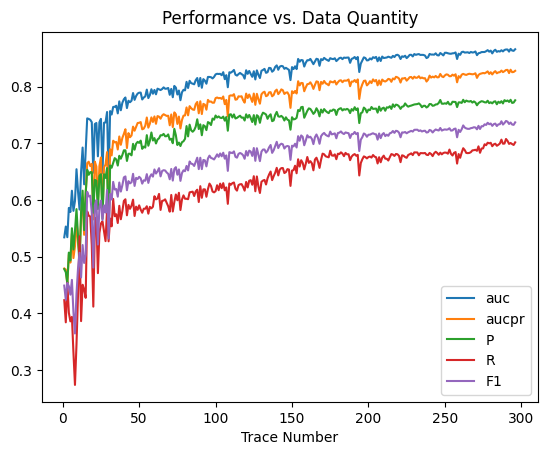

In [12]:
file = '../info/2023-09-09-record.csv'
df = pd.read_csv(file)

x = df['num']
y1 = df['roc_auc']
y2 = df['aucpr']
y3 = df['p']
y4 = df['r']
y5 = df['f1']

plt.plot(x, y1, label = 'auc')
plt.plot(x, y2, label = 'aucpr')
plt.plot(x, y3, label = 'P')
plt.plot(x, y4, label = 'R')
plt.plot(x, y5, label = 'F1')

plt.title('Performance vs. Data Quantity')
plt.xlabel('Trace Number')

plt.legend()
plt.show()

In [ ]:
# L = []
# record_file = '../info/2023-09-09-record2.csv'

# f = open(record_file, 'w')
# f.write(','.join([ 'num', 'rmse', 'mae']) + '\n')

# for i, l in enumerate(train_dir_list):
    
#     L.append(l)
    
#     features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']
    
#     num_of_features = len(features)
    
#     target = ['LTE_HO', 'MN_HO'] # For eNB HO.
#     # target = ['eNB_to_ENDC'] # Setup gNB
#     # target = ['gNB_Rel', 'gNB_HO'] # For gNB HO.
#     # target = ['RLF'] # For RLF
#     # target = ['SCG_RLF'] # For scg failure
#     # target = ['dl-loss'] # For DL loss
#     # target = ['ul-loss'] # For UL loss
    
    
#     # Data
#     print('Loading training data...')
#     X_train, y_train1, y_train2, split_time_train = ts_array_create(dirname, L, time_seq)
#     X_train_2d = X_train.reshape(-1, time_seq*num_of_features)
#     cond = y_train2 > 0
#     X_train_fore = X_train_2d[cond]
#     y_train2_fore = y_train2[cond]


#     print('Loading testing data...')
#     X_test, y_test1, y_test2, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
#     X_test_2d = X_test.reshape(-1, time_seq*num_of_features)
#     cond = y_test2 > 0
#     X_test_fore = X_test_2d[cond]
#     y_test2_fore = y_test2[cond]
    
    
#     model = cb.CatBoostRegressor(iterations=200,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,colsample_bylevel=0.8,
#                               loss_function='RMSE', eval_metric = 'RMSE', early_stopping_rounds=10, random_seed=seed) 
#     model.fit(X_train_fore, y_train2_fore, eval_set=(X_test_fore, y_test2_fore), verbose=False)
#     best_iteration = model.best_iteration_
#     model = cb.CatBoostRegressor(iterations=200,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,colsample_bylevel=0.8,
#                                 loss_function='RMSE', eval_metric = 'RMSE', early_stopping_rounds=10, random_seed=seed) 
#     model.fit(X_train_fore, y_train2_fore, eval_set=(X_test_fore, y_test2_fore), verbose=False)

    
#     preds = model.predict(X_test_fore)    
    
#     rmse = mean_squared_error(y_test2_fore, preds, squared=False)
#     mae = mean_absolute_error(y_test2_fore, preds)
    
#     print(rmse, mae)
    
#     write_list = [ i+1, rmse, mae]
#     write_list = [str(s) for s in write_list]
#     f.write(','.join(write_list) + '\n')
    

# f.close()


In [11]:
f.close()

In [12]:
file = '../info/2023-09-09-record2.csv'
df = pd.read_csv(file)

x = df['num']
y1 = df['rmse']
y2 = df['mae']

plt.plot(x, y1, label = 'rmse')
plt.plot(x, y2, label = 'mae')

plt.title('Performance vs. Data Quantity')
plt.xlabel('Trace Number')

plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../info/2023-09-09-record2.csv'

In [ ]:
# Validate with other route data.

In [13]:
# Time sequence length and prediction time length
time_seq = 20
predict_t = 10
valid_ratio = 0.2

# Define DataSet
dirname = "../data/single"
# dirname = "/home/wmnlab/Documents/sheng-ru/data/single0.5"
dir_list = os.listdir(dirname)
dir_list = [f for f in dir_list if ( f.endswith('.csv') and '08-21' in f) ] # Take out cell phone data

train_dir_list = ['2023-08-21_sm01_#02_LTE.csv',
  '2023-08-21_sm00_#04_All.csv',
  '2023-08-21_sm00_#03_All.csv',
  '2023-08-21_sm00_#05_All.csv',
  '2023-08-21_sm01_#04_LTE.csv',
  '2023-08-21_sm00_#02_All.csv',
  '2023-08-21_sm01_#01_LTE.csv',
  '2023-08-21_sm01_#05_LTE.csv',
  '2023-08-21_sm00_#01_All.csv', '2023-08-21_sm01_#03_LTE.csv']

test_dir_list = ['2023-08-21_sm00_#06_All.csv', '2023-08-21_sm01_#06_LTE.csv']

# train_dir_list += [f for f in os.listdir(dirname) if 'sm' in f] # Add cell phone data.

# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2',
#         'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2' ]
features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
        'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']
# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2']

num_of_features = len(features)

target = ['LTE_HO', 'MN_HO'] # For eNB HO.
# target = ['eNB_to_ENDC'] # Setup gNB
# target = ['gNB_Rel', 'gNB_HO'] # For gNB HO.
# target = ['RLF'] # For RLF
# target = ['SCG_RLF'] # For scg failure
# target = ['dl-loss'] # For DL loss
# target = ['ul-loss'] # For UL loss

In [14]:
train_dir_list, test_dir_list

(['2023-08-21_sm01_#02_LTE.csv',
  '2023-08-21_sm00_#04_All.csv',
  '2023-08-21_sm00_#03_All.csv',
  '2023-08-21_sm00_#05_All.csv',
  '2023-08-21_sm01_#04_LTE.csv',
  '2023-08-21_sm00_#02_All.csv',
  '2023-08-21_sm01_#01_LTE.csv',
  '2023-08-21_sm01_#05_LTE.csv',
  '2023-08-21_sm00_#01_All.csv',
  '2023-08-21_sm01_#03_LTE.csv'],
 ['2023-08-21_sm00_#06_All.csv', '2023-08-21_sm01_#06_LTE.csv'])

In [13]:
L = []
record_file = '../info/2023-09-10-record.csv'

f = open(record_file, 'w')
f.write(','.join([ 'num','roc_auc', 'aucpr', 'p', 'r', 'f1']) + '\n')

for i, l in enumerate(train_dir_list):
    
    L.append(l)
    
    features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
        'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']
    
    num_of_features = len(features)
    
    target = ['LTE_HO', 'MN_HO'] # For eNB HO.
    # target = ['eNB_to_ENDC'] # Setup gNB
    # target = ['gNB_Rel', 'gNB_HO'] # For gNB HO.
    # target = ['RLF'] # For RLF
    # target = ['SCG_RLF'] # For scg failure
    # target = ['dl-loss'] # For DL loss
    # target = ['ul-loss'] # For UL loss
    
    
    # Data
    print('Loading training data...')
    X_train, y_train1, y_train2, split_time_train = ts_array_create(dirname, L, time_seq)
    X_train_2d = X_train.reshape(-1, time_seq*num_of_features)
    cond = y_train2 > 0
    X_train_fore = X_train_2d[cond]
    y_train2_fore = y_train2[cond]


    print('Loading testing data...')
    X_test, y_test1, y_test2, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
    X_test_2d = X_test.reshape(-1, time_seq*num_of_features)
    cond = y_test2 > 0
    X_test_fore = X_test_2d[cond]
    y_test2_fore = y_test2[cond]
    
    model2 = cb.CatBoostClassifier(iterations=200,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,
                              colsample_bylevel=0.8, scale_pos_weight=1,
                              loss_function='Logloss', eval_metric = 'F1', early_stopping_rounds=10, random_seed=seed) 
    
    model2.fit(X_train_2d, y_train1, eval_set=(X_test_2d, y_test1), verbose=False, init_model=model)
    # 選擇最佳迭代次數
    best_iteration = model2.best_iteration_

    # 使用最佳迭代次數重新訓練模型
    model2 = cb.CatBoostClassifier(iterations=best_iteration,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,
                                colsample_bylevel=0.8, scale_pos_weight=1,
                                loss_function='Logloss', eval_metric = 'F1', early_stopping_rounds=10, random_seed=seed)
    model2.fit(X_train_2d, y_train1, eval_set=(X_test_2d, y_test1), verbose=False, init_model=model)
    
    preds = model2.predict_proba(X_test_2d)[:, 1]
    
    # PR and AUCPR
    precision, recall, thresholds = precision_recall_curve(y_test1, preds)
    
    p = precision_score(y_test1, [1 if (p >= 0.5) else 0 for p in preds]) 
    r = recall_score(y_test1, [1 if (p >= 0.5) else 0 for p in preds])
    f1 = f1_score(y_test1, [1 if (p >= 0.5) else 0 for p in preds])
    
    aucpr = auc(recall, precision)
    
    # ROC & AUC
    fpr, tpr, thresholds = roc_curve(y_test1, preds)
    roc_auc = auc(fpr, tpr)
    
    print(i, roc_auc, aucpr, p, r, f1)
    write_list = [ i+1, roc_auc, aucpr, p, r, f1]
    write_list = [str(s) for s in write_list]
    f.write(','.join(write_list) + '\n')
    

f.close()


Loading training data...


  0%|          | 0/1 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

CatBoostError: /src/catboost/catboost/private/libs/options/boosting_options.cpp:65: Iterations count should be positive

In [16]:
file = '../info/2023-09-10-record.csv'
df = pd.read_csv(file)

x = df['num']
y1 = df['roc_auc']
y2 = df['aucpr']
y3 = df['p']
y4 = df['r']
y5 = df['f1']

plt.plot(x, y1, label = 'auc')
plt.plot(x, y2, label = 'aucpr')
plt.plot(x, y3, label = 'P')
plt.plot(x, y4, label = 'R')
plt.plot(x, y5, label = 'F1')

plt.title('Performance vs. Data Quantity')
plt.xlabel('Trace Number')

plt.legend()
plt.show()

EmptyDataError: No columns to parse from file

# Train

In [14]:
model = cb.CatBoostClassifier(iterations=200,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,
                              colsample_bylevel=0.8, scale_pos_weight=1,
                              loss_function='Logloss', eval_metric = 'F1', early_stopping_rounds=10, random_seed=seed) 

In [15]:
model.fit(X_train_2d, y_train1, eval_set=(X_test_2d, y_test1), verbose=False)
# 選擇最佳迭代次數
best_iteration = model.best_iteration_

# 使用最佳迭代次數重新訓練模型
model = cb.CatBoostClassifier(iterations=best_iteration,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,
                              colsample_bylevel=0.8, scale_pos_weight=1,
                              loss_function='Logloss', eval_metric = 'F1', early_stopping_rounds=10, random_seed=seed)
model.fit(X_train_2d, y_train1, eval_set=(X_test_2d, y_test1), verbose=False)

In [16]:
preds = model.predict_proba(X_test_2d)[:, 1]

th: 0.2; Acc: 43.18642253736478; precision: 0.43; recall:1.0; f1:0.6
th: 0.3; Acc: 43.18642253736478; precision: 0.43; recall:1.0; f1:0.6
th: 0.4; Acc: 43.18642253736478; precision: 0.43; recall:1.0; f1:0.6
th: 0.5; Acc: 51.072206719926605; precision: 0.45; recall:0.57; f1:0.5
th: 0.6; Acc: 56.81357746263522; precision: DNF; recall:DNF; f1:DNF
th: 0.7; Acc: 56.81357746263522; precision: DNF; recall:DNF; f1:DNF
th: 0.8; Acc: 56.81357746263522; precision: DNF; recall:DNF; f1:DNF


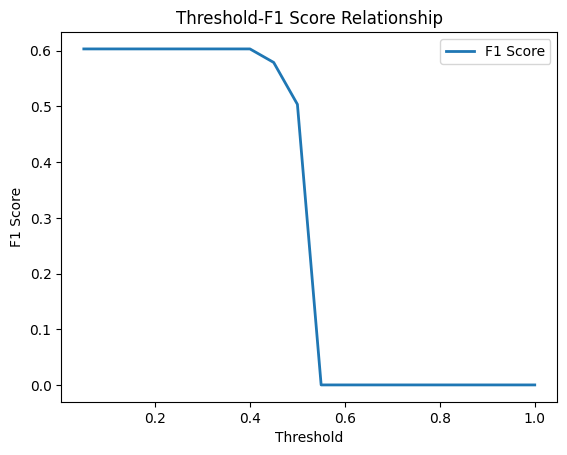

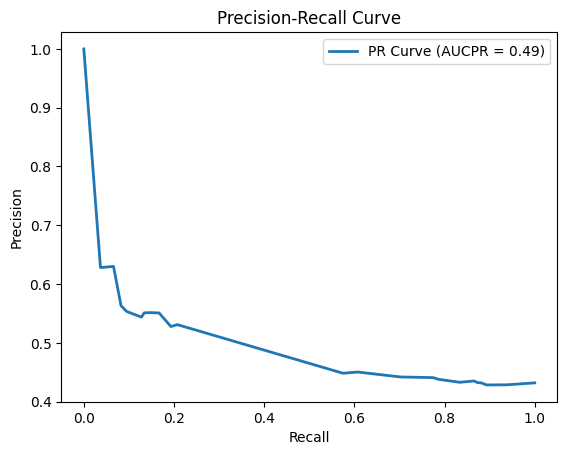

ROC Auc is 0.5343980360806906.


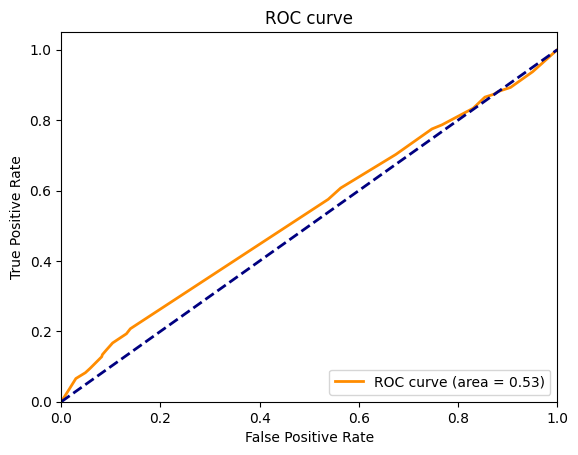

In [17]:
# plot all data point on a plot
ths = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]

if task == 'forecast':
    rmse = round(np.sqrt(np.mean((preds-y_test1)**2)), 2)
    mae = np.mean(np.abs(preds-np.array(y_test1)))
    print(f'RMSE is {rmse}. MAE is {mae}')
elif task == 'classification':
    # PR and AUCPR
    precision, recall, thresholds = precision_recall_curve(y_test1, preds)
    aucpr = auc(recall, precision)
    
    # ROC & AUC
    fpr, tpr, thresholds = roc_curve(y_test1, preds)
    roc_auc = auc(fpr, tpr)
    
    # Manually count
    for threshold in ths:
        TP, FP, TN, FN = 0,0,0,0
        anses = np.where(preds<threshold, 0, 1)
        for ans, y in zip(anses, y_test1):
            if ans == y:
                if ans == 1: TP += 1
                elif ans == 0: TN +=1
            elif ans != y:
                if ans == 1: FP += 1
                elif ans == 0: FN +=1
        acc=(TP+TN)/(TP+TN+FP+FN)*100
        try:
            p, r = round(TP/(TP+FP), 2), round(TP/(TP+FN), 2)
            f1 = round(2*(p*r)/(p+r), 2)
        except:
            p, r, f1 = 'DNF', 'DNF', 'DNF'
        s = f'th: {threshold}; Acc: {acc}; precision: {p}; recall:{r}; f1:{f1}'
        print(s)
    
    # 初始化閥值列表和 F1 Score 列表
    thresholds = []
    f1_scores = []

    # 循環遍歷閥值，計算 F1 Score
    for threshold in range(5, 101, 5):
        threshold /= 100
        y_pred_threshold = [1 if pred >= threshold else 0 for pred in preds]
        f1_scores.append(f1_score(y_test1, y_pred_threshold))
        thresholds.append(threshold)

    # 繪製閥值與 F1 Score 的關係圖
    plt.figure()
    plt.plot(thresholds, f1_scores, lw=2, label='F1 Score')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('Threshold-F1 Score Relationship')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(recall, precision, lw=2, label='PR Curve (AUCPR = %0.2f)' % aucpr)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()
    
    print(f'ROC Auc is {roc_auc}.')
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(f'ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [18]:
# Save Model
model.save_model('../model/nr_HO_cls_cb')

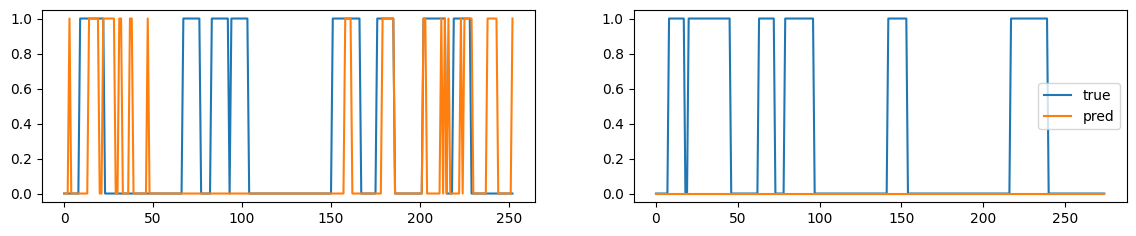

In [19]:
# visulized on many sample on validation data
sample_value = 2
# samples = random.sample(split_time_test, sample_value)
samples = [split_time_test[8], split_time_test[9]]

fig, axs = plt.subplots(1, sample_value, figsize=(14, 2.5))

# y_test
# preds

for i in range(sample_value):
    true = [y_test1[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(true, label='true')
    # prediciton = [preds[i] for i in range(samples[i][0], samples[i][1])]
    prediciton = [1 if preds[i] > 0.5 else 0 for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(prediciton, label='pred')

plt.legend()
plt.show()

In [20]:
A = [test_dir_list[split_time_test.index(s)] for s in samples]
A

['2023-06-13_sm04_#02_B3B7.csv', '2023-04-01_qc00_exp1_#05_B1.csv']

In [21]:
# Check whethet it do good on training data
sample_value = 2
samples = random.sample(split_time_train, sample_value)
preds_train = model.predict(X_train_2d)

fig, axs = plt.subplots(1, sample_value, figsize=(14, 2.5))

for i in range(sample_value):
    true = [y_train1[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(true, label='true')
    prediciton = [preds_train[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(prediciton, label='pred')

plt.legend()
plt.show()

ValueError: Sample larger than population or is negative

# grid search

In [ ]:
import itertools

iterations =  [100, 200, 300]
learning_rates = [0.1, 0.01, 0.001]
depths = [4, 6, 8, 10]
l2_leaf_regs = [0.1, 1, 10]
border_counts =  [5, 10, 20]
colsample_bylevels = [0.5, 0.8, 1]
scale_pos_weights = [1, 2, 5]

In [ ]:
f_out = 'lte_ho_cls_cb.csv'
f_out = open(f_out, 'w')
cols_out = ['iteration','learning_rate','depth', 'l2_leaf_reg', 'border_count','colsample_bylevel','scale_pos_weight','auc','aucpr', 'p', 'r', 'f1','acc']
f_out.write(','.join(cols_out)+'\n')

for itera, lr, dep, l2_leaf, bc, cbl, spw in itertools.product(iterations, learning_rates, depths, l2_leaf_regs, border_counts, colsample_bylevels, scale_pos_weights):
    
    print(itera, lr, dep, l2_leaf, bc, cbl, spw)
    model = cb.CatBoostClassifier(iterations=itera,  learning_rate = lr, depth = dep, l2_leaf_reg = l2_leaf, 
                                  border_count = bc, colsample_bylevel= cbl,scale_pos_weight = spw, 
                              loss_function='Logloss', eval_metric = 'F1', early_stopping_rounds=10, random_seed=seed)
    
    model.fit(X_train_2d, y_train1, eval_set=(X_test_2d, y_test1), verbose=False)
    
    preds = model.predict_proba(X_test_2d)[:, 1]
    
    # AUCPR
    precision, recall, thresholds = precision_recall_curve(y_test1, preds)
    aucpr = auc(recall, precision)

    # ROC & AUC
    fpr, tpr, thresholds = roc_curve(y_test1, preds)
    roc_auc = auc(fpr, tpr)
    threshold = 0.5

    p = precision_score(y_test1, [1 if pred > threshold else 0 for pred in preds])
    r = recall_score(y_test1, [1 if pred > threshold else 0 for pred in preds])
    f1 = f1_score(y_test1, [1 if pred > threshold else 0 for pred in preds])
    acc = accuracy_score(y_test1, [1 if pred > threshold else 0 for pred in preds])
    
    cols_out = [itera, lr, dep, l2_leaf, bc, cbl, spw, roc_auc, aucpr, p, r, f1, acc]
    cols_out = [str(n) for n in cols_out]
    f_out.write(','.join(cols_out)+'\n')
    
f_out.close()

In [ ]:
import pandas as pd
df = pd.read_csv('lte_ho_cls_cb.csv')
max_value = df['aucpr'].max()
max_index = df['aucpr'].idxmax()
print(df.iloc[max_index])
max_value = df['auc'].max()
max_index = df['auc'].idxmax()
print(df.iloc[max_index])


# Forecast

In [ ]:
model = cb.CatBoostRegressor(iterations=200,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,colsample_bylevel=0.8,
                              loss_function='RMSE', eval_metric = 'RMSE', early_stopping_rounds=10, random_seed=seed) 

In [ ]:
model.fit(X_train_fore, y_train2_fore, eval_set=(X_test_fore, y_test2_fore), verbose=False)
best_iteration = model.best_iteration_
model = cb.CatBoostRegressor(iterations=200,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,colsample_bylevel=0.8,
                              loss_function='RMSE', eval_metric = 'RMSE', early_stopping_rounds=10, random_seed=seed) 
model.fit(X_train_fore, y_train2_fore, eval_set=(X_test_fore, y_test2_fore), verbose=False)

In [ ]:
preds = model.predict(X_test_fore)

In [ ]:
rmse = mean_squared_error(y_test2_fore, preds, squared=False)
mae = mean_absolute_error(y_test2_fore, preds)
rmse, mae

In [ ]:
model.save_model('../model/nr_HO_fst_cb')

# Load Model

In [ ]:
model = cb.CatBoostClassifier()      # parameters not required.
model.load_model('../model/nr_HO_cls_cb')

In [ ]:
preds = model.predict_proba(X_test_2d)[:, 1]

In [ ]:
# plot all data point on a plot
ths = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]

# PR and AUCPR
precision, recall, thresholds = precision_recall_curve(y_test1, preds)
aucpr = auc(recall, precision)

# ROC & AUC
fpr, tpr, thresholds = roc_curve(y_test1, preds)
roc_auc = auc(fpr, tpr)

# Manually count
for threshold in ths:
    TP, FP, TN, FN = 0,0,0,0
    anses = np.where(preds<threshold, 0, 1)
    for ans, y in zip(anses, y_test1):
        if ans == y:
            if ans == 1: TP += 1
            elif ans == 0: TN +=1
        elif ans != y:
            if ans == 1: FP += 1
            elif ans == 0: FN +=1
    acc=(TP+TN)/(TP+TN+FP+FN)*100
    try:
        p, r = round(TP/(TP+FP), 2), round(TP/(TP+FN), 2)
        f1 = round(2*(p*r)/(p+r), 2)
    except:
        p, r, f1 = 'DNF', 'DNF', 'DNF'
    s = f'th: {threshold}; Acc: {acc}; precision: {p}; recall:{r}; f1:{f1}'
    print(s)

# 初始化閥值列表和 F1 Score 列表
thresholds = []
f1_scores = []

# 循環遍歷閥值，計算 F1 Score
for threshold in range(5, 101, 5):
    threshold /= 100
    y_pred_threshold = [1 if pred >= threshold else 0 for pred in preds]
    f1_scores.append(f1_score(y_test1, y_pred_threshold))
    thresholds.append(threshold)

print(f'roc_auc: {roc_auc}')
print(f'aucpr: {aucpr}')

In [ ]:
model = cb.CatBoostRegressor()     # parameters not required.
model.load_model('../model/nr_HO_fst_cb')

In [ ]:
preds = model.predict(X_test_fore)

In [ ]:
rmse = mean_squared_error(y_test2_fore, preds, squared=False)
mae = mean_absolute_error(y_test2_fore, preds)
rmse, mae

In [ ]:
preds